# Classical Computer Vision SIFT
Here we implement a computer vision algorithm to search for lookalike signals.

In [1]:
import pandas as pd
import numpy as np
from blimpy import Waterfall
import cv2 as cv

In [2]:
def normalize(data):
    epsilon = 1
    # min_val = data.min()
    # data = data - min_val + epsilon
    # new_data = np.log(data)
    min_val = data.min()
    max_val = data.max()
    final_data = (data - min_val) / (max_val - min_val)
    return final_data

# Load SOI 

In [3]:
import pickle

with open('SOI.pkl', 'rb') as handle:
    SOI = pickle.load(handle)
print(SOI)

# GBT_57907_34727_HIP87579_fine
# GBT_57907_35736_HIP87225_fine

{'GBT_57907_34727_HIP87579_fine': {'freq': 1961.273217201233, 'start': 1961.2728595733643, 'end': 1961.2735748291016, 'directory': '/mnt_blpd7/datax/dl/GBT_57907_34727_HIP87579_fine.h5', 'stats': 3280.7677441581645}, 'GBT_57907_35736_HIP87225_fine': {'freq': 2486.045980453491, 'start': 2486.0456228256226, 'end': 2486.04633808136, 'directory': '/mnt_blpd7/datax/dl/GBT_57907_35736_HIP87225_fine.h5', 'stats': 2671.2570601076177}, 'GBT_57907_36075_HIP87579_fine': {'freq': 2190.6482219696045, 'start': 2190.647864341736, 'end': 2190.648579597473, 'directory': '/mnt_blpd7/datax/dl/GBT_57907_36075_HIP87579_fine.h5', 'stats': 7185.910082141092}, 'GBT_57907_35062_HIP87059_fine': {'freq': 1955.3888082504272, 'start': 1955.3884506225586, 'end': 1955.389165878296, 'directory': '/mnt_blpd7/datax/dl/GBT_57907_35062_HIP87059_fine.h5', 'stats': 2306.6694979143826}, 'GBT_57907_36414_HIP87278_fine': {'freq': 1949.9671697616577, 'start': 1949.966812133789, 'end': 1949.9675273895264, 'directory': '/mnt_blp

In [4]:
import pickle

df = pd.read_csv("../data_generator/test_directories.csv")

with open('SOI.pkl', 'rb') as handle:
    SOI = pickle.load(handle)

target1_converted = '/datag/pipeline/AGBT17A_999_76/holding/spliced_blc0001020304050607_guppi_57907_34727_HIP87579_0032.gpuspec.0000.h5'
    
target1 = SOI[list(SOI.keys())[0]]
data = Waterfall("../../../../../../../"+target1_converted, 
                 f_start = target1["start"], f_stop=target1["end"]).data

In [5]:
# target1 = SOI["GBT_57907_34727_HIP87579_fine"]
print(target1)
# data = Waterfall("../../../../../../../"+target1["directory"], 
#                  f_start = target1["start"], f_stop=target1["end"]).data
data = normalize(data)*255
data = data.astype('uint8')
print(data.max(), data.min())
data = np.swapaxes(data, 1, -1)
sift = cv.SIFT_create()
kp, des_SOI = sift.detectAndCompute(data,None)
print(des_SOI.shape)

{'freq': 1961.273217201233, 'start': 1961.2728595733643, 'end': 1961.2735748291016, 'directory': '/mnt_blpd7/datax/dl/GBT_57907_34727_HIP87579_fine.h5', 'stats': 3280.7677441581645}
255 0
(1, 128)


# Load Data
This data is the dataset we wish to search through

In [6]:
total_data = Waterfall("../../../../../../../"+target1_converted, max_load=False).data

## SIFT Centroids
Here we first loop through all the data and compute the SIFT for each. Then we compute the centroids by using kmeans

In [7]:
from tqdm import tqdm
num_samples = total_data.shape[-1]//256
# num_samples = 100_000
new_total_data = np.zeros((num_samples, 16, 256))

des_vecs = []
kps_vecs = []
sift = cv.SIFT_create()

for i in tqdm(range(num_samples)):
    temp =  normalize(total_data[:,0,i*256:(i+1)*256]) *255
    new_total_data[i, :,:] =temp
    temp = temp.astype('uint8')
    kp, des = sift.detectAndCompute(temp, None)
    des_vecs.append(des)
    kps_vecs.append(kp)

100%|████████████████████████████████| 1404928/1404928 [27:51<00:00, 840.57it/s]


In [8]:
des_vecs[0].shape

(5, 128)

In [9]:
# descriptors = np.vstack(list(filter(lambda x: x is not None, des_vecs)))
# clusters = 800
# criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 5, .01)
# centroids = cv.kmeans(descriptors, clusters, None, criteria, 1, cv.KMEANS_PP_CENTERS)[2]
# np.save("centroids.npy", centroids)

In [10]:
clusters = 800
centroids = np.load("centroids.npy")

In [11]:
from tqdm import tqdm
num_samples = total_data.shape[-1]//256
new_total_data = np.zeros((num_samples, 16, 256))

bf = cv.BFMatcher()
# bf = cv.DescriptorMatcher_create(cv.DescriptorMatcher_FLANNBASED)
histograms = []
for i in tqdm(range(num_samples)):
    counter = np.zeros((clusters,), dtype=np.uint32)
    temp =  normalize(total_data[:,0,i*256:(i+1)*256]) *255
    new_total_data[i, :,:] =temp
    temp = temp.astype('uint8')
    kp, des = sift.detectAndCompute(temp, None)
    if des is None:
        histograms.append(counter)
        continue
    matches = bf.knnMatch(des, centroids, k=1)
    for match in matches:
        counter[match[0].trainIdx] += 1
    counter_sum = np.sum(counter)
    counter = [float(n)/counter_sum for n in counter]
    histograms.append(counter)

100%|████████████████████████████████| 1404928/1404928 [52:09<00:00, 448.94it/s]


# SIFT SOI

In [12]:
matches_SOI = bf.knnMatch(des_SOI, centroids, k=1)
counter_SOI = np.zeros((clusters,), dtype=np.uint32)   
for match in matches_SOI:
    counter_SOI[match[0].trainIdx] += 1
counter_sum_SOI = np.sum(counter_SOI)
histogram_SOI = [float(n)/counter_sum_SOI for n in counter_SOI]

In [13]:
len(histograms)

1404928

# Final Search

In [14]:
matcher = cv.DescriptorMatcher_create(cv.DescriptorMatcher_FLANNBASED)
final_matches = matcher.knnMatch(np.float32([histogram_SOI]), np.float32(histograms), k=10)

In [15]:
best_index = []
for match in final_matches:
    for sub in match:
        best_index.append(sub.trainIdx)
best_index

[305589,
 1016312,
 1175945,
 1175959,
 1177247,
 1177333,
 1192140,
 1193953,
 1198360,
 1217098]

In [16]:
SOI = Waterfall("../../../../../../../"+target1_converted, 
                 f_start = target1["start"], f_stop=target1["end"]).data
SOI = normalize(SOI)

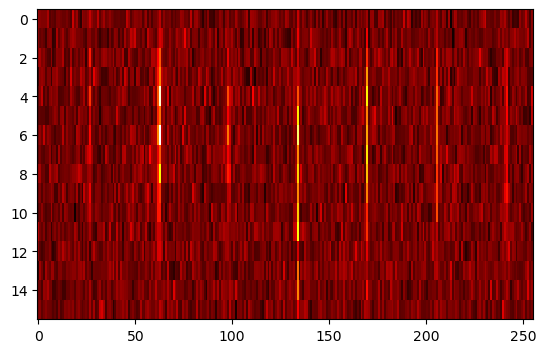

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(SOI[:, 0,:], cmap='hot', interpolation='nearest', aspect=10)

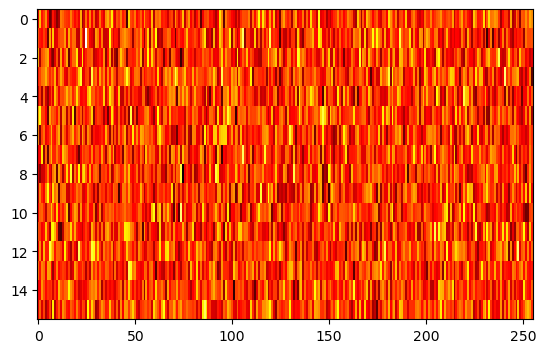

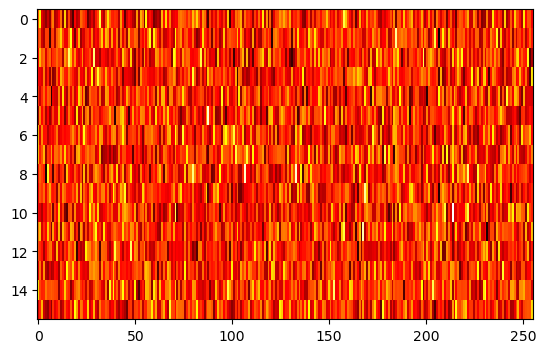

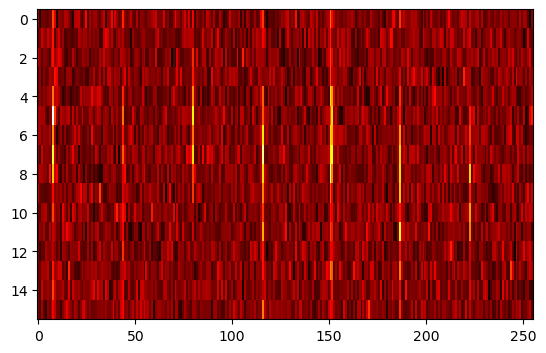

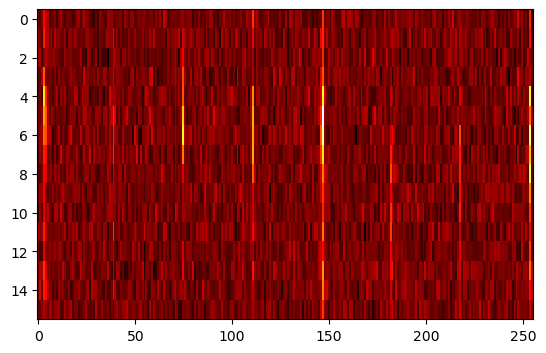

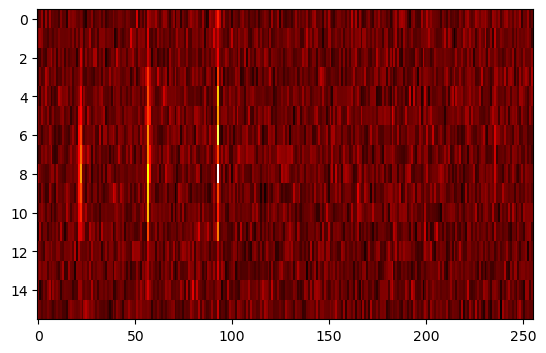

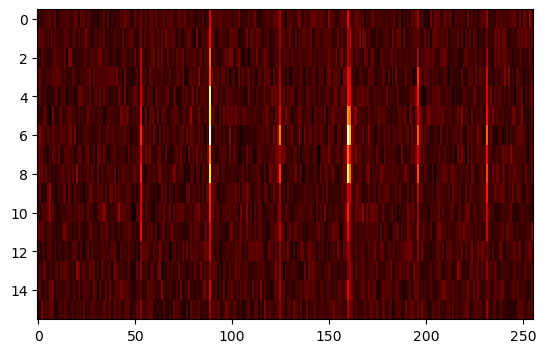

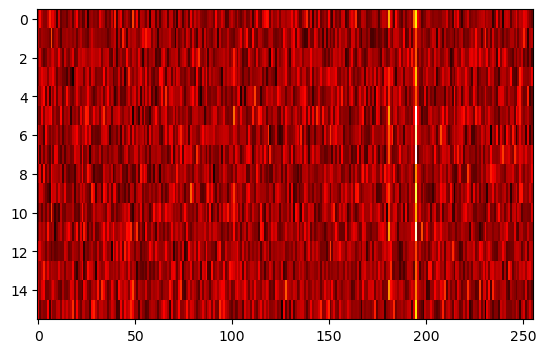

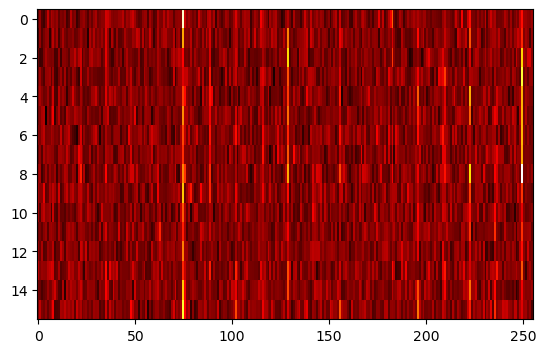

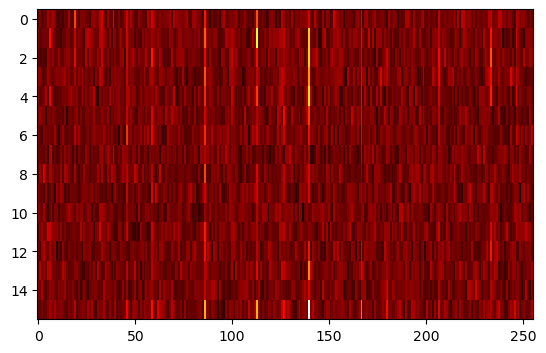

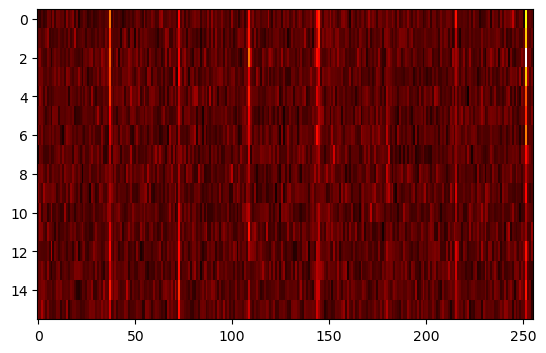

In [18]:
for i in range(10):
    plt.figure()
    plt.imshow(new_total_data[best_index[i],:, :], cmap='hot', interpolation='nearest', aspect=10)

# New Best Target Matcher

In [19]:
eps = 0.0000001
key_features = np.float32(histograms)
SOI_feature = np.float32([histogram_SOI])
print(SOI_feature.shape)
SOI_feature = np.swapaxes(SOI_feature, 0, -1)
SOI_norm = np.linalg.norm(SOI_feature) + eps
data_norm = np.linalg.norm(key_features, axis = 1) + eps
print(key_features.shape)
similarity = np.matmul(key_features, SOI_feature)[:,0]
similarity = np.divide(similarity, data_norm)/SOI_norm
print(similarity)
best_index = (-similarity).argsort()[:-1000]
print(similarity.max())
print(best_index)

(1, 800)
(1404928, 800)
[0. 0. 0. ... 0. 0. 0.]
0.99999976
[1192318  338212  615056 ...  469801  469800  469799]


In [20]:
best_index[0]

1192318

In [21]:
from tqdm import tqdm
def normalize(data):
    epsilon = 1
    min_val = data.min()
    data = data - min_val + epsilon
    new_data = np.log(data)
    min_val = data.min()
    max_val = data.max()
    final_data = (data - min_val) / (max_val - min_val)
    return final_data
    
def normalize_data(data):
    new_data = np.zeros((data.shape[-1]//256, 16, 256,1))
    for i in tqdm(range(new_data.shape[0])):
        new_data[i,:,:, 0] = normalize(data[:,0, i*256:(i+1)*256])
    return new_data

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2720.04it/s]


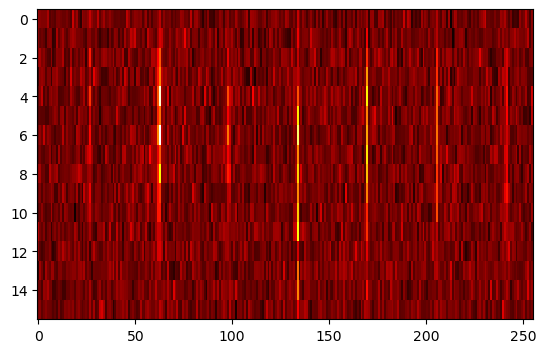

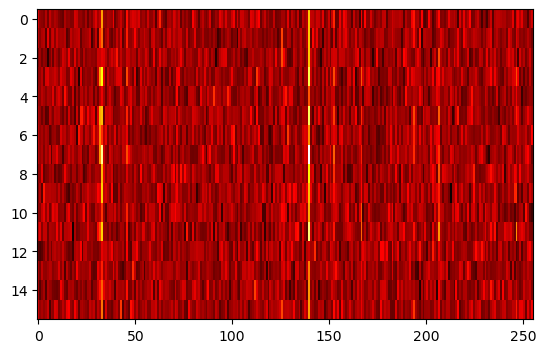

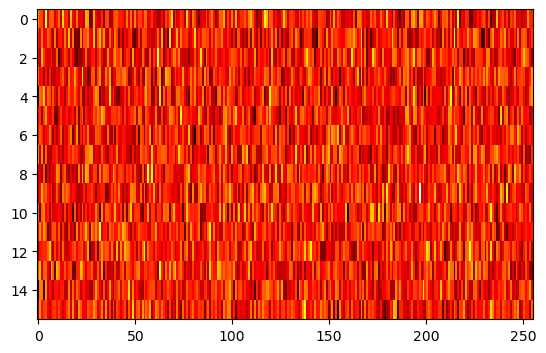

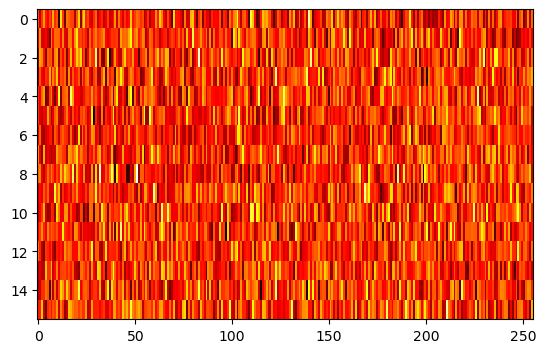

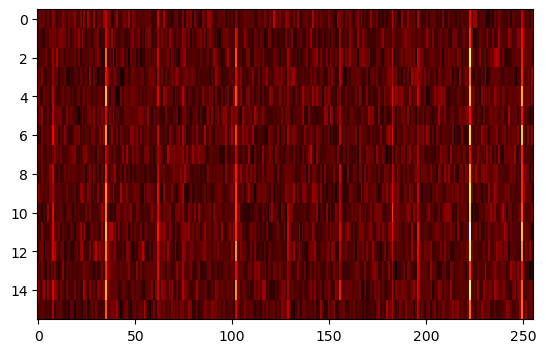

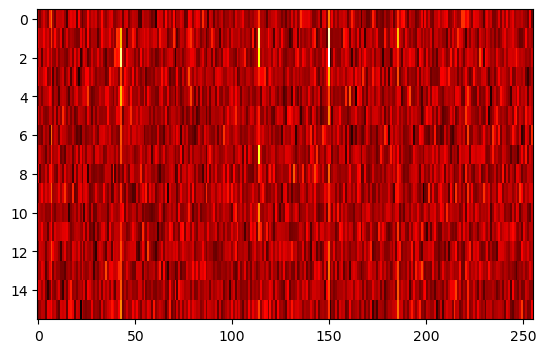

In [22]:
%matplotlib inline
target1_data = data = Waterfall("../../../../../../../"+target1_converted, 
                 f_start = target1["start"], f_stop=target1["end"]).data

data_stuff = Waterfall("../../../../../../../"+target1_converted, max_load=False).data
preprocessed_data = normalize_data(data_stuff)

plt.figure()
plt.imshow(normalize_data(target1_data)[0,:,:,0], cmap='hot', interpolation='nearest', aspect=10)

for i in range(5):
    plt.figure()
    plt.imshow(preprocessed_data[best_index[i],:, :], cmap='hot', interpolation='nearest', aspect=10)

### Get some header information

In [23]:
header = Waterfall("../../../../../../../"+target1_converted, 
                 load_data = False).header
end = header['fch1']
foff = header['foff']
nchan = header['nchans']
start = end+nchan*foff
print(start, end)
intervals = (end-start)/ preprocessed_data.shape[0]
print(intervals)
print( target1["start"])

1797.94921875 2802.83203125
0.0007152557373046875
1961.2728595733643


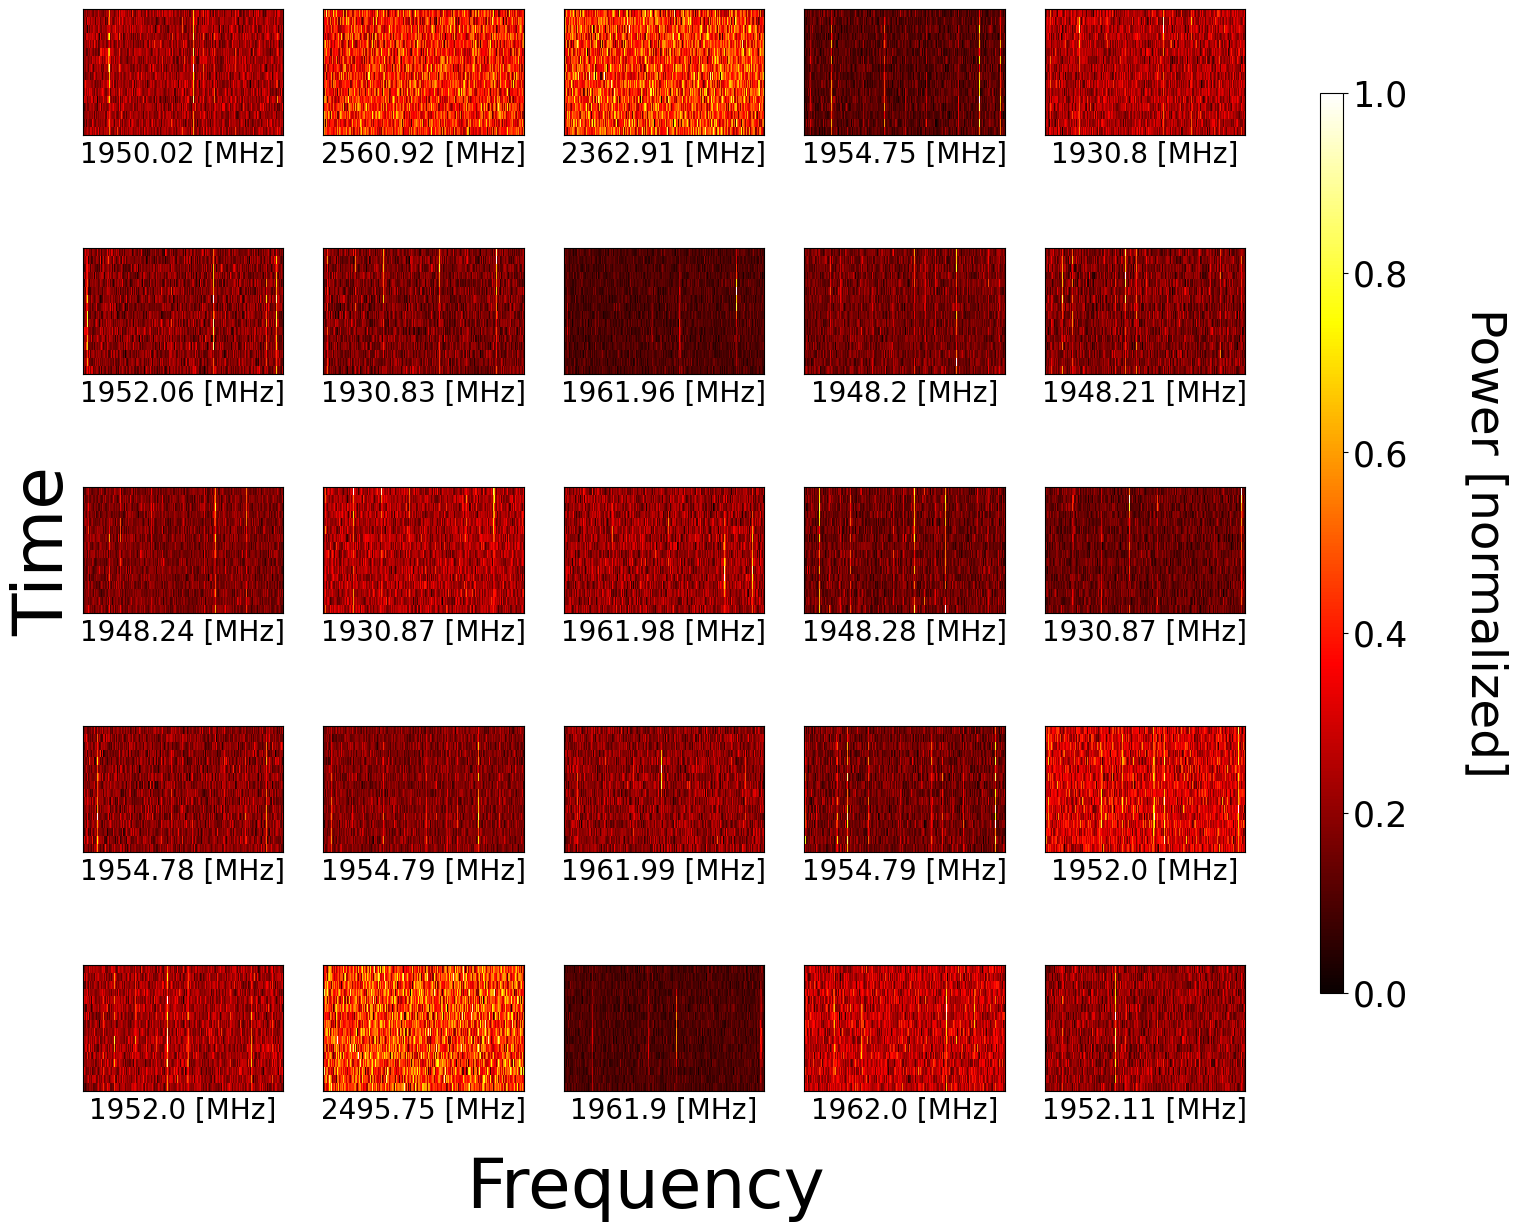

In [24]:
font_size = 25
plt.rcParams.update({'font.size': font_size})
f, ax = plt.subplots(nrows=5, ncols=5, figsize=(15,15))

count = 0
row_count = 0
for row in ax:
    col_count = 0 
    for col in row:
        im = col.imshow(preprocessed_data[best_index[count],:, :], cmap='hot', interpolation='nearest', aspect=10)
        freq = end-best_index[count]*intervals
        col.set_xlabel(str(round(freq, 2))+" [MHz]",  fontsize=font_size-5)  
        col.get_xaxis().set_ticks([])
        col.get_yaxis().set_ticks([])
        if col_count ==0 and row_count == 2:
            col.set_ylabel("Time",  fontsize=font_size*2)  
        col_count+=1
        count += 1 
    row_count += 1
    
f.text(0.5, 0.07, 'Frequency', ha='center', va='center', rotation=0, 
       fontsize=font_size*2)


cbaxes = f.add_axes([0.95, 0.2, 0.015, 0.6]) 
cbar = f.colorbar(im, cax=cbaxes)
cbar.ax.tick_params(labelsize=font_size)
f.text(1.06, 0.5, 'Power [normalized]', ha='center', va='center', rotation=270, 
       fontsize=font_size+10)

plt.show()

# Check Distribution

In [25]:
1176584*intervals+end

3644.3904876708984

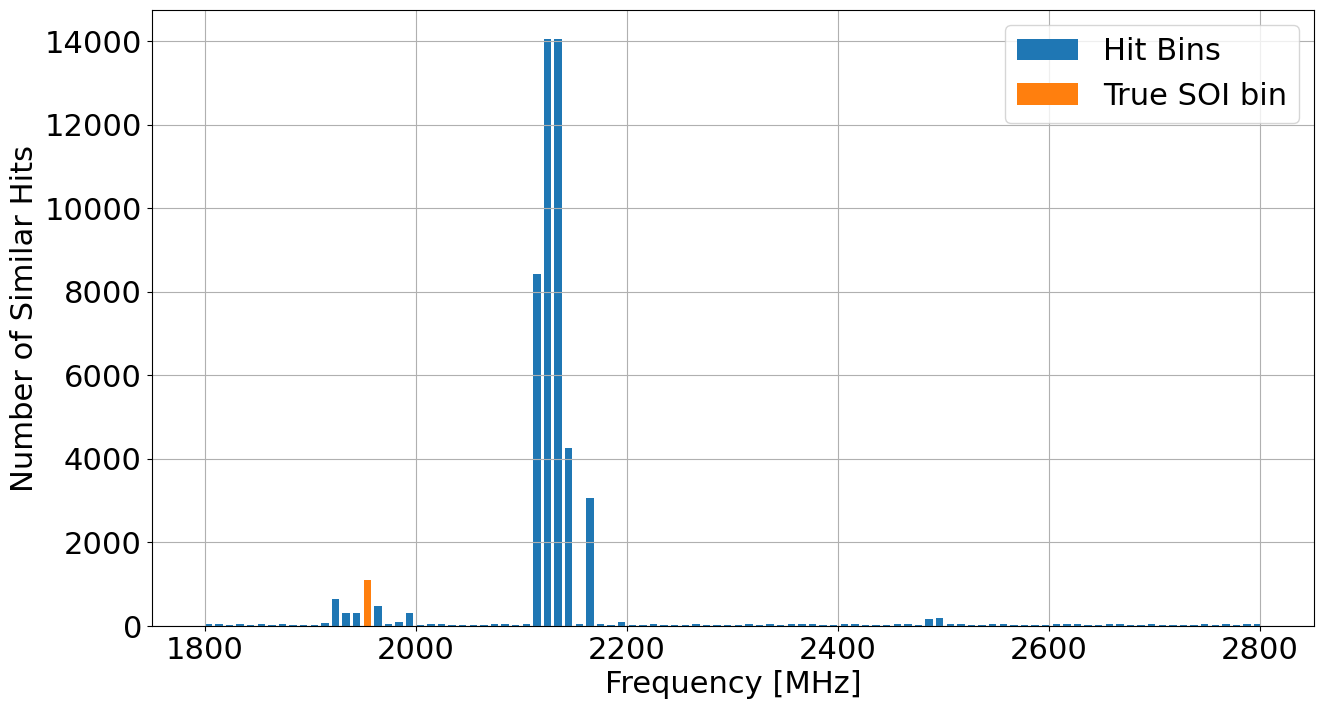

In [26]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(15,8))
hist, bins = np.histogram(end-best_index[:50000]*intervals, bins=100)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width, label="Hit Bins")
key = 0
for i in range(len(center)):
    if center[i] > target1["start"]:
        key = i
        break
plt.bar(center[key-1], hist[key-1], align='center', width=width, label="True SOI bin")
plt.ylabel("Number of Similar Hits")
plt.xlabel("Frequency [MHz]")
plt.grid()
plt.legend()

# Merge Plots Together

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5302.53it/s]


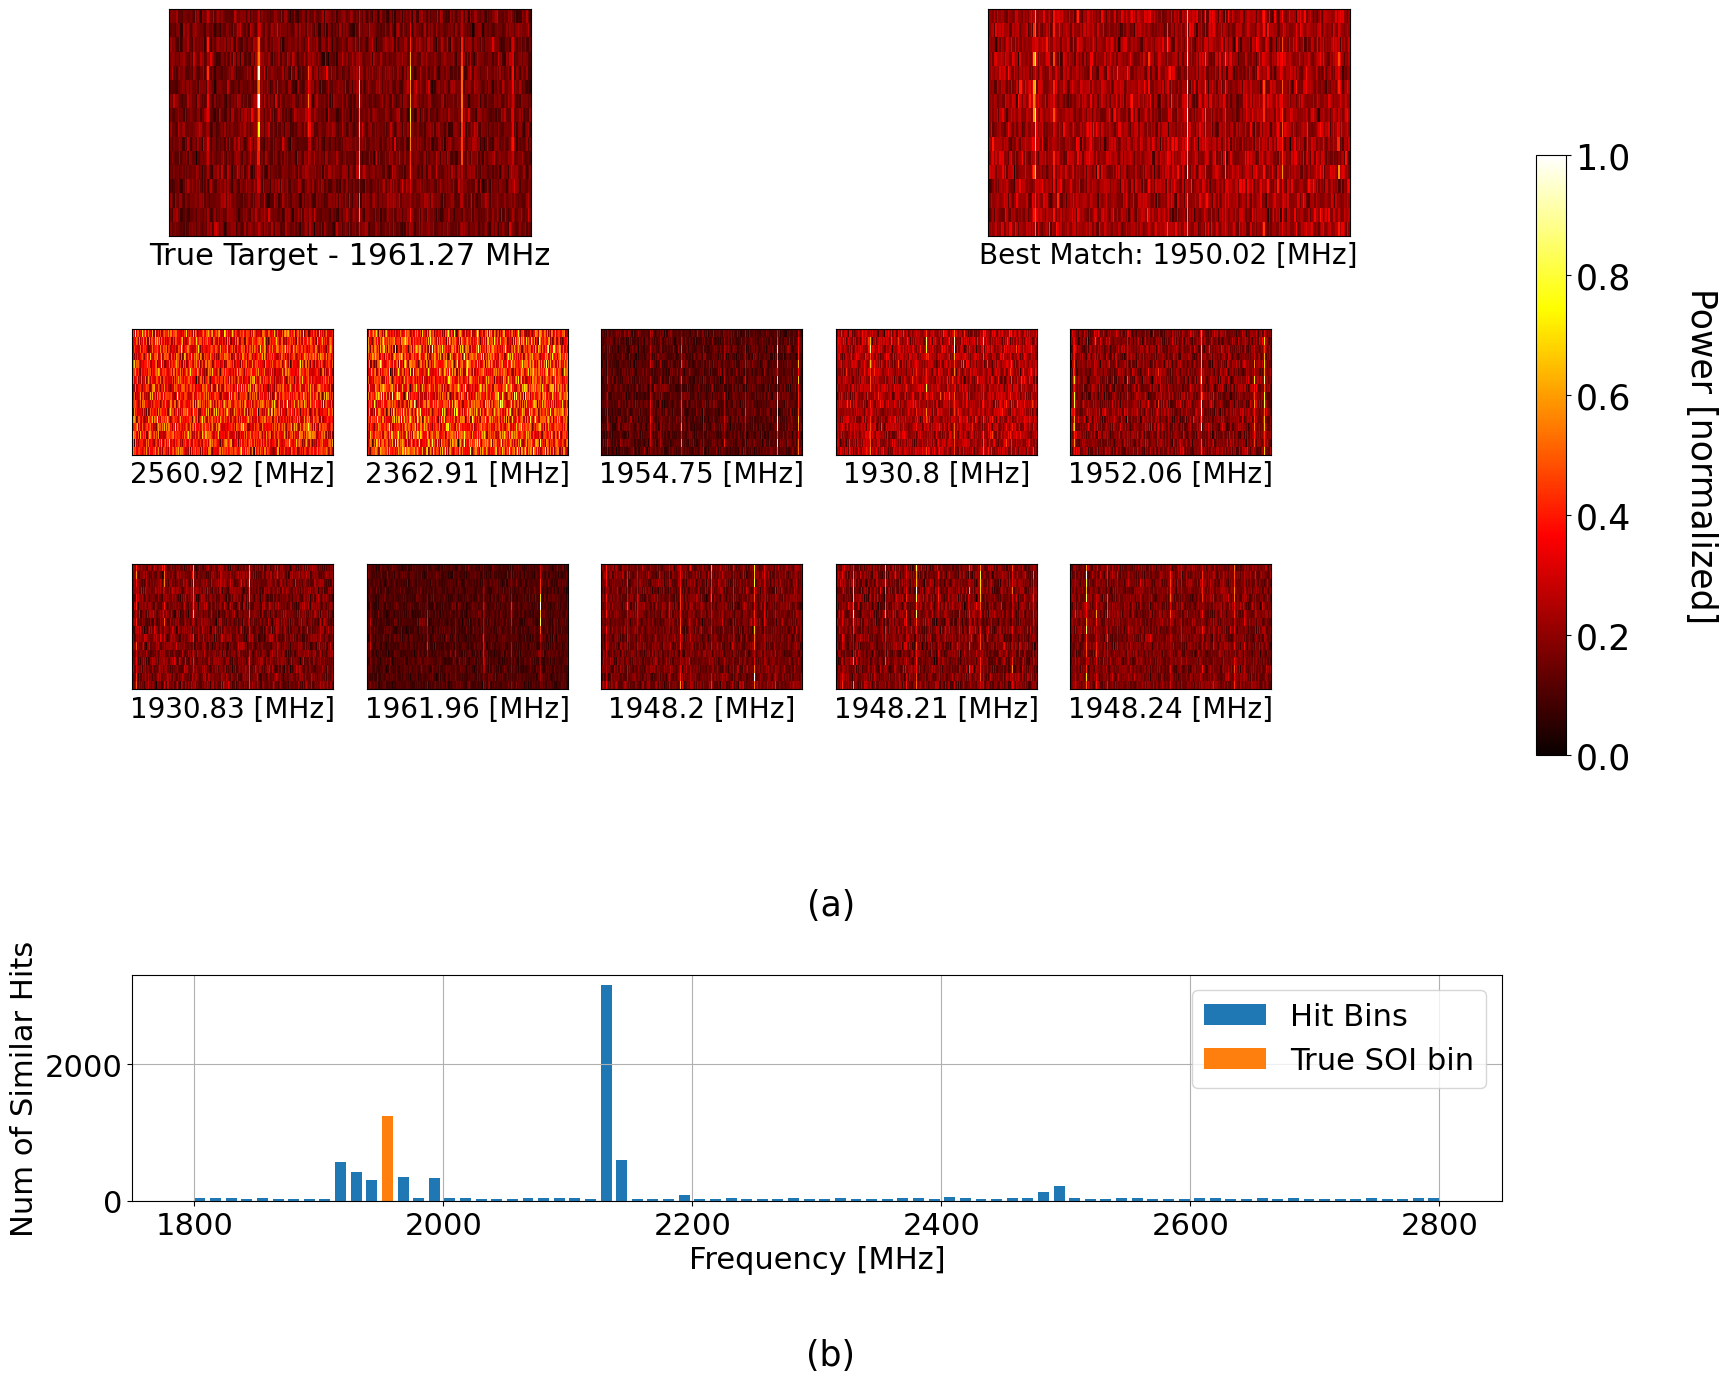

In [28]:
fig = plt.figure(figsize=(15, 15), layout="constrained")
spec = fig.add_gridspec(6, 6)

main = fig.add_subplot(spec[0, 0:2])
im = main.imshow(normalize_data(target1_data)[0,:,:,0], cmap='hot', interpolation='nearest', aspect=10)
main.get_xaxis().set_ticks([])
main.get_yaxis().set_ticks([])
main.set_xlabel("True Target - "+str(round(target1["start"], 2))+" MHz")

ax0 = fig.add_subplot(spec[0, 3:])
im = ax0.imshow(preprocessed_data[best_index[0],:, :], cmap='hot', interpolation='nearest', aspect=10)
ax0.get_xaxis().set_ticks([])
ax0.get_yaxis().set_ticks([])
freq = end-best_index[0]*intervals
ax0.set_xlabel("Best Match: "+str(round(freq, 2))+" [MHz]",  fontsize=font_size-5)          
count = 1
for i in range(1,3):
    for j in range(5):
        ax = fig.add_subplot(spec[i, j])
        im = ax.imshow(preprocessed_data[best_index[count],:, :], cmap='hot', interpolation='nearest', aspect=10)
        freq = end-best_index[count]*intervals
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.set_xlabel(str(round(freq, 2))+" [MHz]",  fontsize=font_size-5)  
        count +=1

fig.text(0.55, 0.40, '(a)', ha='center', va='center', rotation=0, fontsize=font_size)
# histogram
ax1 = fig.add_subplot(spec[4:5, :])  
hist, bins = np.histogram(end-best_index[:10000]*intervals, bins=80)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width, label="Hit Bins")
key = 0
for i in range(len(center)):
    if center[i] > target1["start"]:
        key = i
        break
ax1.bar(center[key-1], hist[key-1], align='center', width=width, label="True SOI bin")
ax1.legend()        
ax1.grid()     
ax1.set_xlabel("Frequency [MHz]")
ax1.set_ylabel("Num of Similar Hits")

# ax2 = fig.add_subplot(spec[4:, :])  

cbaxes = fig.add_axes([1.02, 0.5, 0.02, 0.4]) 
cbar = fig.colorbar(im, cax=cbaxes)
cbar.ax.tick_params(labelsize=font_size)
fig.text(1.13, 0.70, 'Power [normalized]', ha='center', va='center', rotation=270, 
       fontsize=font_size)

fig.text(0.55, 0.1, '(b)', ha='center', va='center', rotation=0, 
       fontsize=font_size)


target_name = target1['directory'].split("/")[-1].split('.')[0]
# plt.savefig("bvae-plots/full_algo-"+target_name+".pdf", format="pdf")
plt.savefig("plots/classical/classical-algo"+target_name+"1.pdf", format="pdf")